In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scienceplots
import os
import seaborn as sns

torch.manual_seed(40)

plt.style.use(['science', 'bright'])
plt.rcParams['figure.dpi'] = 300

In [2]:
from src.simulator.prior import get_prior
from src.simulator.simulator import create_simulator
from src.inference.utils import load_model

prior = get_prior()
simulator = create_simulator()
density_estimator = load_model(os.path.join("..", "results", "inference", "trained_model_10.pkl"))

c:\Users\Julian\anaconda3\envs\sbi_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\users\julian\documents\cmb-sbi-inference\src\inference\utils.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We

In [3]:
from sbi.inference import SNPE_C

inference = SNPE_C(prior=prior)
posterior = inference.build_posterior(density_estimator)
print(posterior)

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [4]:
true_parameter = torch.tensor([0.02212, 0.1206, 1.04077, 0.0522, 3.04, 0.9626])
x_observed = simulator(true_parameter)

torch.manual_seed(40)
samples = posterior.set_default_x(x_observed).sample((25000,))

Drawing 25000 posterior samples: 27504it [00:01, 16156.59it/s]                           


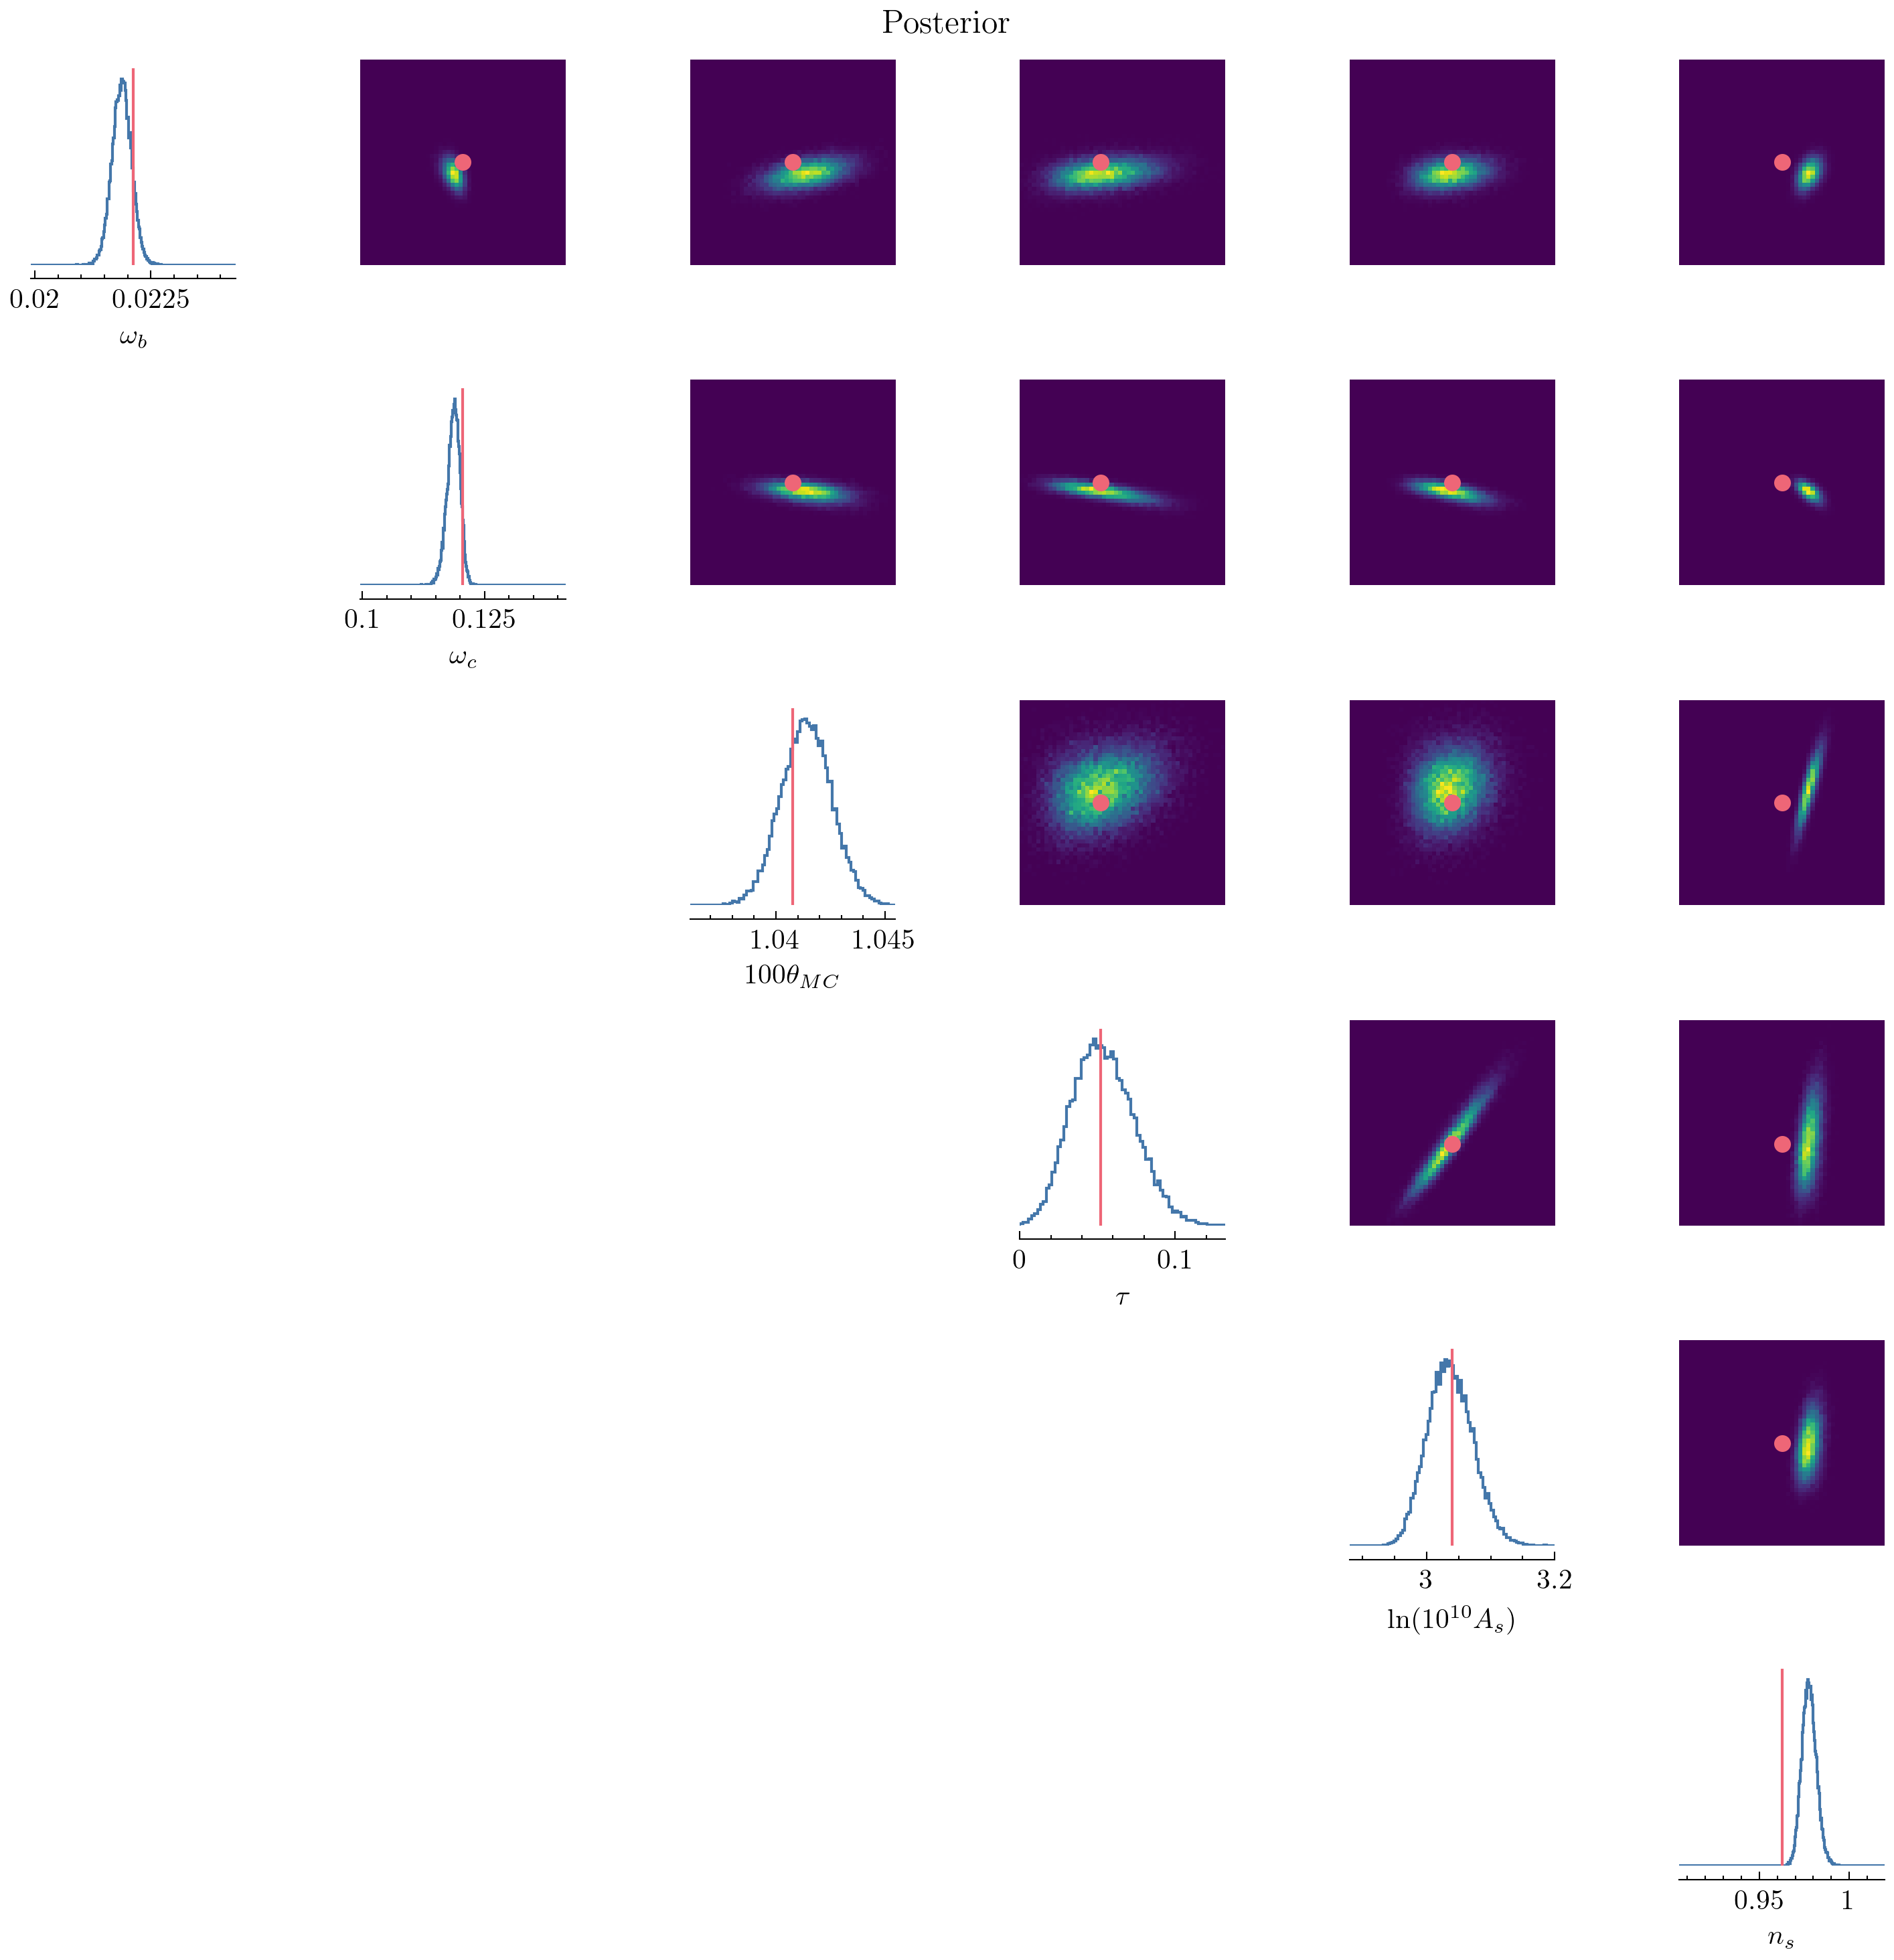

In [5]:
from sbi.analysis import pairplot

# --- LÍMITES DEL PRIOR ---
limits = torch.tensor([
    [0.01992, 0.02432],    
    [0.0996, 0.1416],  
    [1.03607, 1.04547],   
    [0.00, 0.1322],    
    [2.88, 3.2],    
    [0.9056, 1.0196],  
])

param_names = [r'$\omega_b$', r'$\omega_c$', r'$100\theta_{MC}$', r'$\tau$', r'$\ln(10^{10}A_s)$', r'$n_s$']

fig = pairplot(
    samples,
    points=true_parameter,
    figsize=(10, 10),
    limits=limits,
    labels=param_names
)

plt.suptitle('Posterior')
plt.tight_layout()
plt.show()

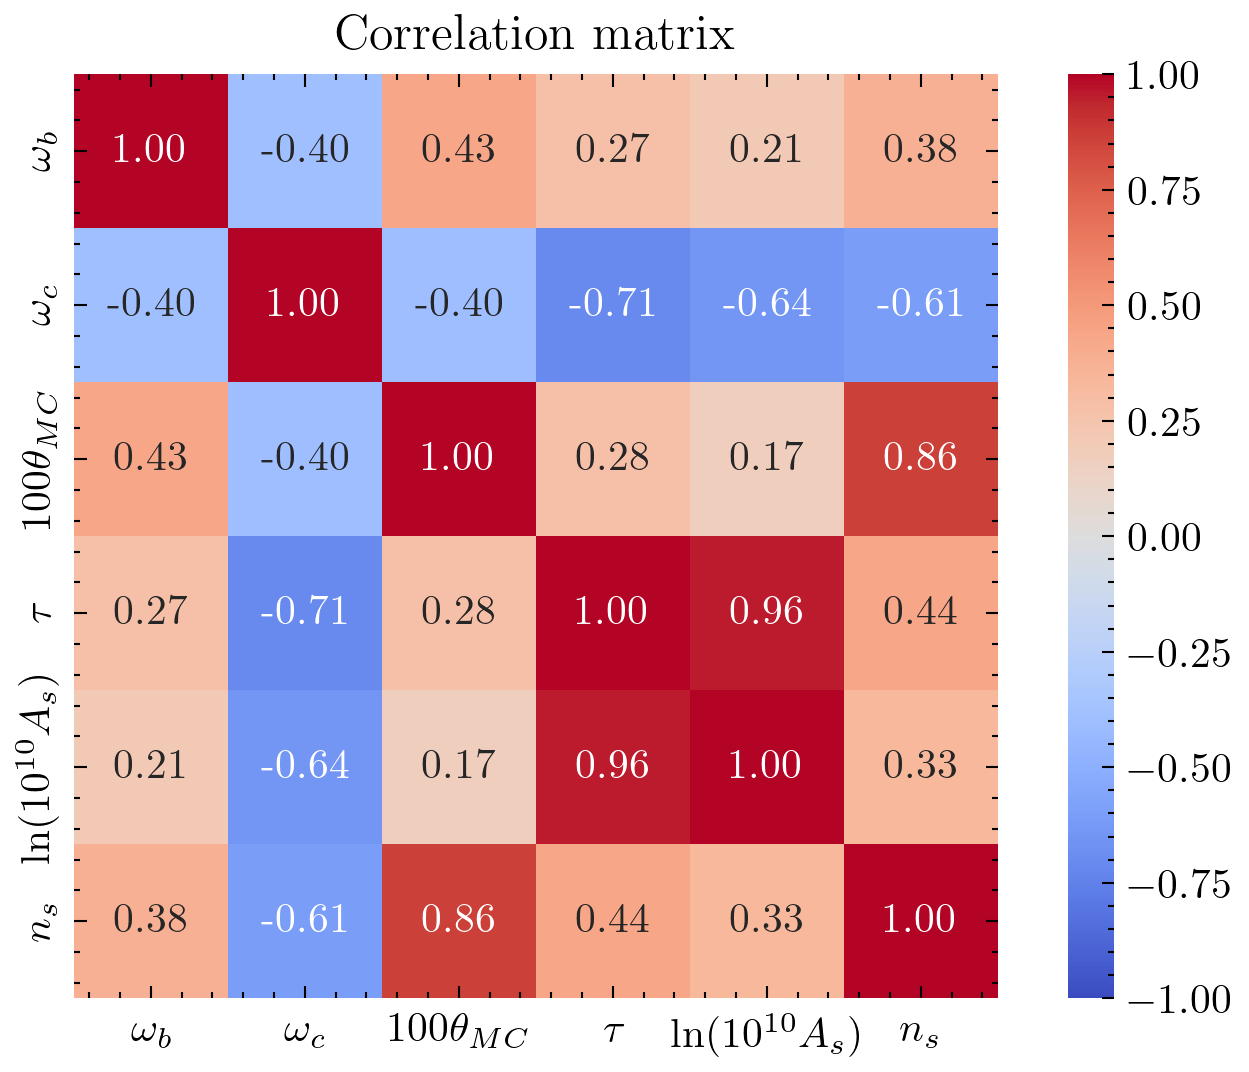

In [6]:
samples_np = samples.numpy()  
correlation_matrix = np.corrcoef(samples_np.T)  

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, xticklabels=param_names, yticklabels=param_names, vmin=-1, vmax=1)
plt.title("Correlation matrix")
plt.show()

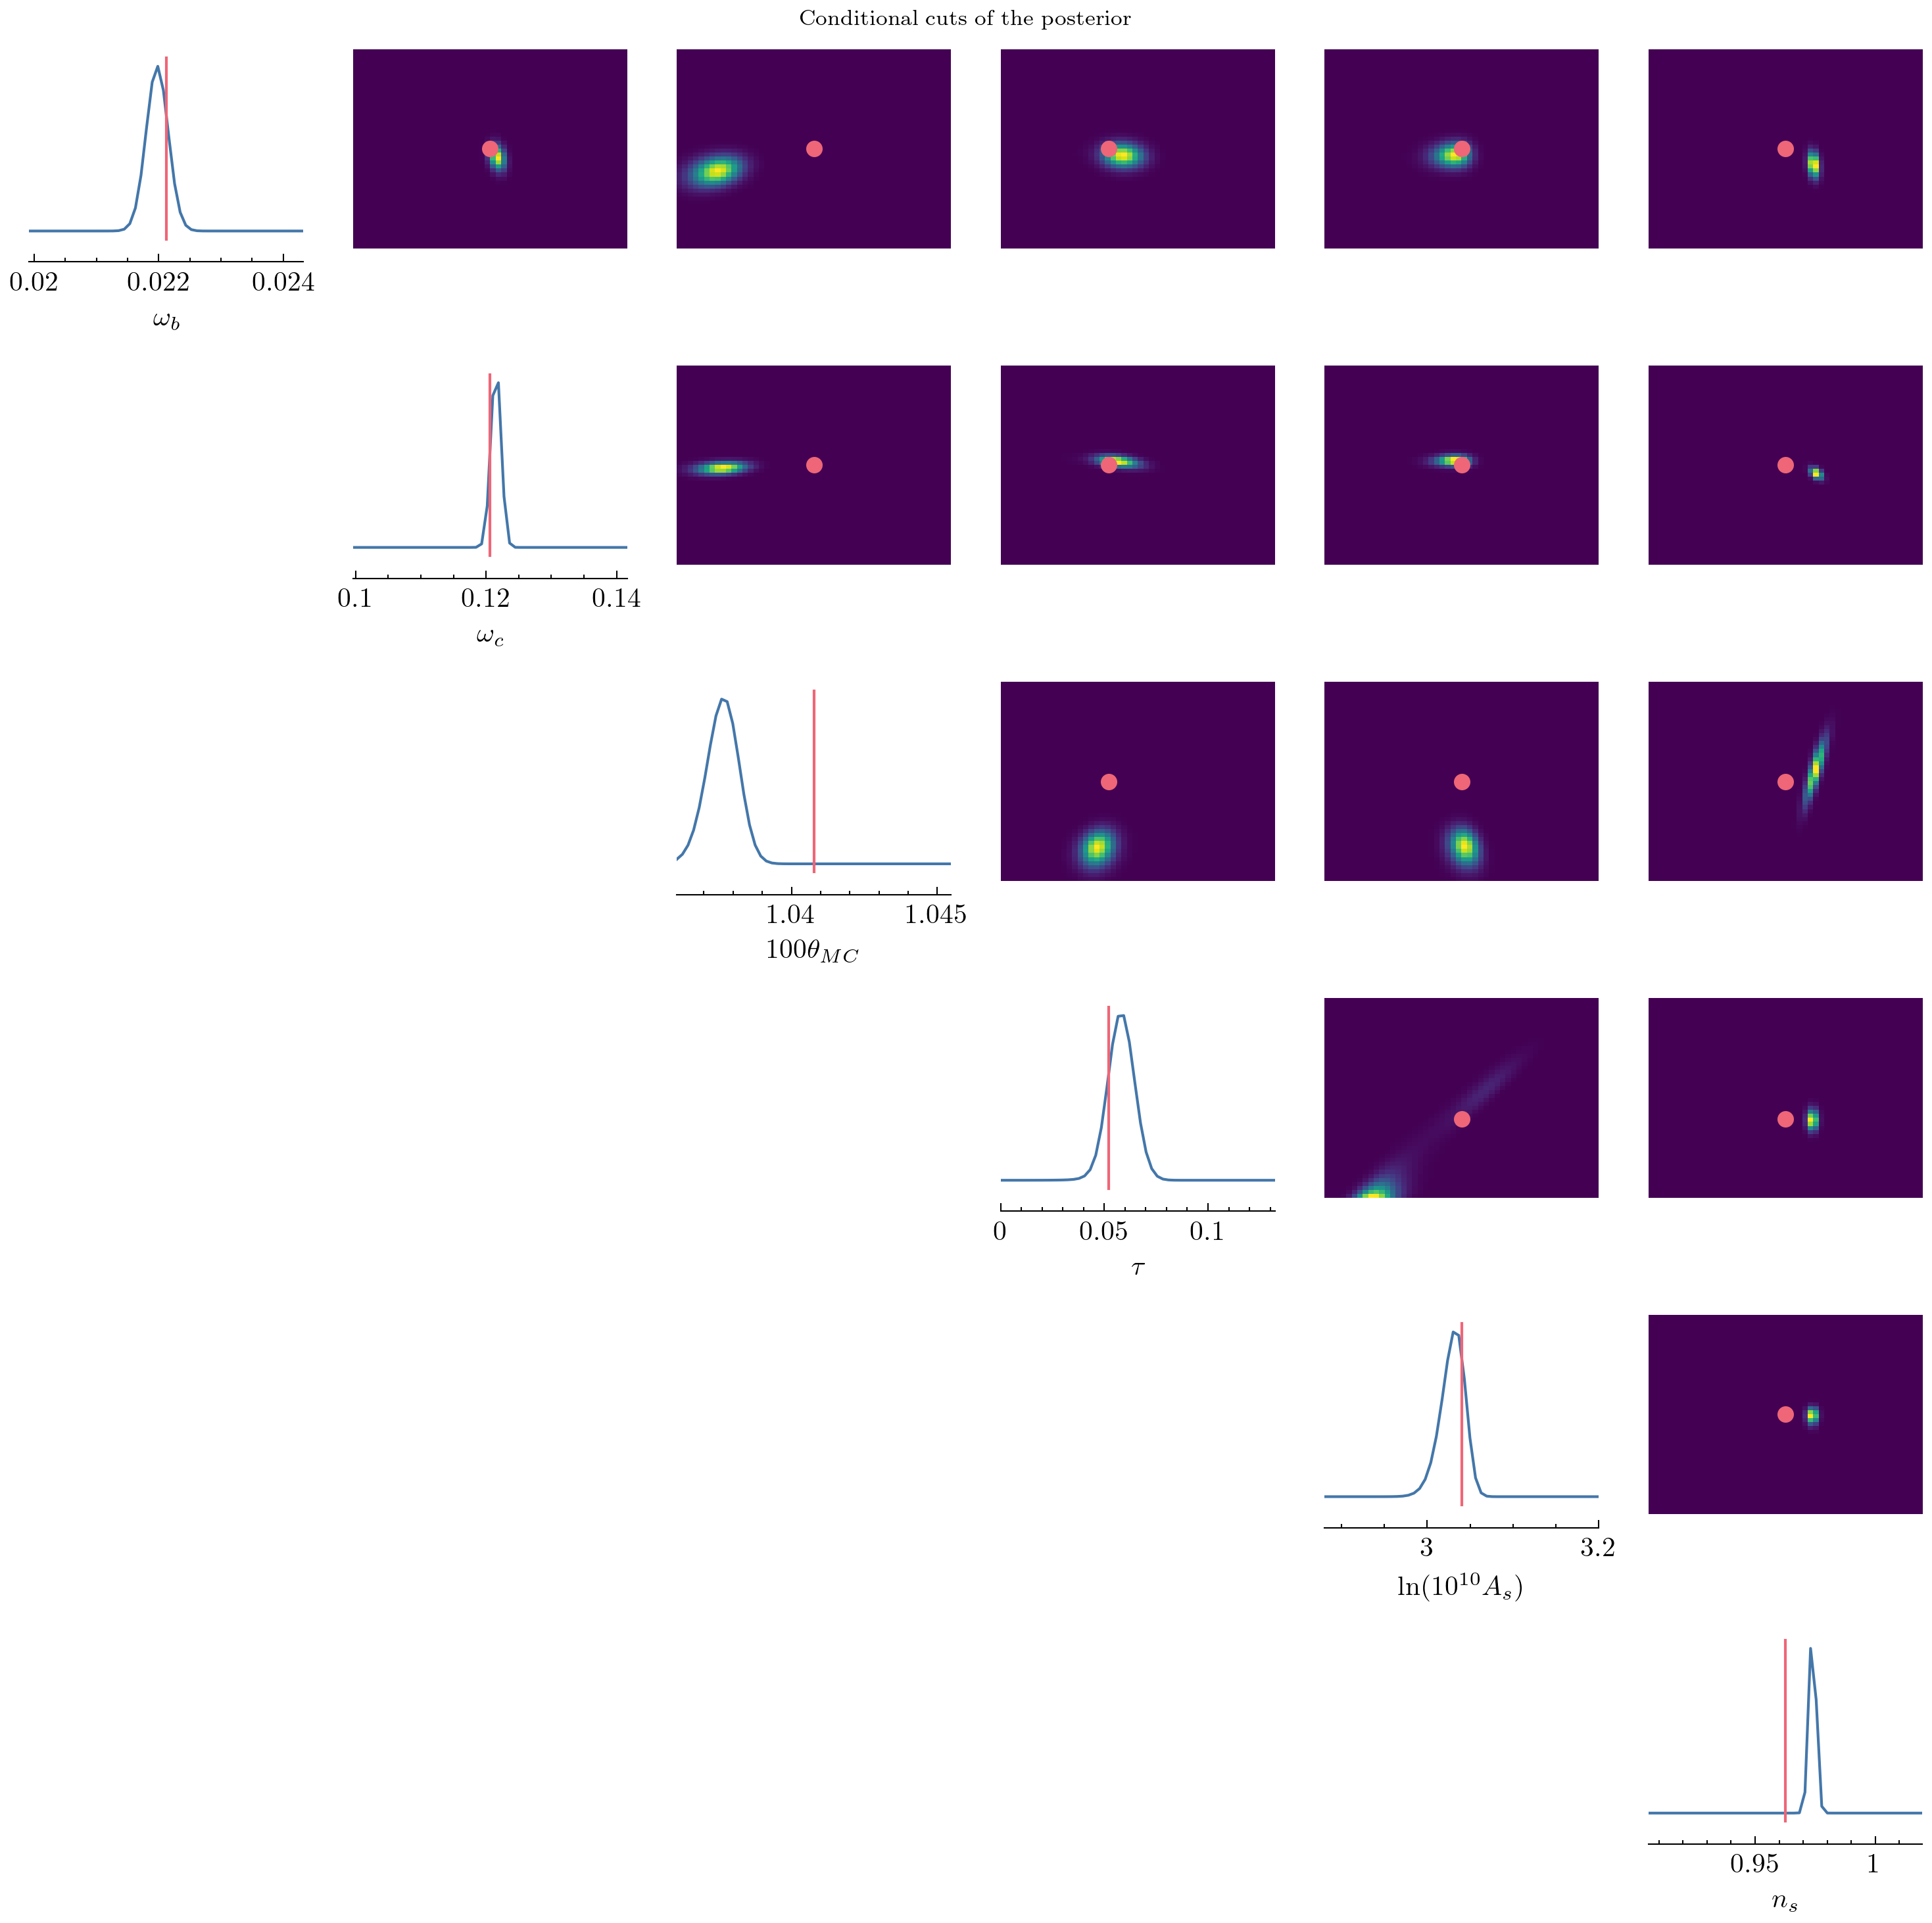

In [7]:
from sbi.analysis import conditional_pairplot

condition = true_parameter

_ = conditional_pairplot(
    density=posterior,
    condition=condition,
    limits=limits,
    figsize=(10, 10),
    labels=param_names,
    points=true_parameter
)
plt.suptitle("Conditional cuts of the posterior", fontsize=8)
plt.tight_layout()
plt.show()